# A/B Testing

In A/B testing, we want to evaluate the performance of the **treatment** relative to **control**.

In this notebook, we will explore the critical steps in an A/B test. From the scenario presented [^1], the goal is to _improve user retention_.

The current game difficulty setting is _hard_ (control), and the assumption is lowering the difficulty to _medium_ (treatment) will improve user retention from 70% to 75%.

| Type | Notes | Retention (%) |
| - | - | - |
| control | difficulty setting _hard_ | 70% |
| treatment | difficulty setting _medium_ | 75% (desired) |


There are other calculators available, such as [^2] or [^3]

References:

[^1]: https://datastud.dev/posts/ab-testing
[^2]: https://stats.stackexchange.com/questions/605466/how-to-get-python-statsmodels-to-match-evan-millers-famous-ab-test-sample-size
[^3]: https://abtestguide.com/abtestsize/
- https://blog.marvik.ai/2023/07/31/making-the-right-changes-using-a-b-testing-to-optimize-your-product/

## Minimum Detectable Effect

In order for us to calculate the _sample size_ that we need to collect for the experiment, we first need to calculate the _minimum detectable effect_. The increase from 70% to 75% gives us the information required to calculate the MDE.

In [1]:
import statsmodels.api as sm

# From 70% to 75%
init_prop = 0.70
mde_prop = 0.75
effect_size = sm.stats.proportion_effectsize(init_prop, mde_prop)
print(
    "From a change from {:.2f} to {:.2f}, the effect size is {:.3f}".format(
        init_prop, mde_prop, effect_size
    )
)

From a change from 0.70 to 0.75, the effect size is -0.112


## Sample Size

Once we have our MDE, we can calculate the sample size required.

We set `nobs1` (number of observations of sample 1) parameter to `None`, which signifies this is the value we are looking to solve.

A **significance level of 0.05** and **power of 0.8** are commonly chosen default values, but can be adjusted based on the scenario and the desired false positive vs false negative sensitivity (?)

NOTE:

`tt_ind_solve_power` and `zt_ind_solve_power` are shortcut functions in the statsmodels power module that can solve for any parameter in the power equations. The main difference between the two is how they treat the internal energy change. 
- tt_ind_solve_power: Calculates the sample size for a two independent sample t-test. It requires the following parameters:
    - effect_size: The standardized effect size, which is the difference between the two means divided by the standard deviation. This value must be positive.
- zt_ind_solve_power: Calculates the desired sample size for a z-test scenario. It requires the following parameters:
    - Minimum size of the effect


In [2]:
from math import ceil

# sm.stats.tt_ind_solve_power
sample_size = sm.stats.zt_ind_solve_power(
    effect_size=effect_size, nobs1=None, alpha=0.05, power=0.8
)
print(
    "{} sample size required given power analysis and input parameters".format(
        ceil(sample_size)
    )
)

1250 sample size required given power analysis and input parameters


In [3]:
import statsmodels.stats.api as sms

# Alternative
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05)
required_n

1249.5838647379314

## Experiment Data Overview

We need to collect a random sample of 1,250 players that played the _medium_ level and the same amount of players that played the _hard_ level.

For simulation, we assumed 980 users (of 1,250) continued playing after reaching the _medium_ difficulty level while 881 (of 1,250) continued playing after reaching the _hard_ difficulty level.

# Performing the z-test

In [4]:
# Get the z test requirements.
medium_successes = 980  # treatment, (roughly 78%, 980/1250)
hard_successes = 881  # control, (roughly 70%, 881/1250)
trials = 1250

In [5]:
medium_successes / trials, hard_successes / trials

(0.784, 0.7048)

In [6]:
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_value = proportions_ztest(
    count=[hard_successes, medium_successes], nobs=trials  # [control, treatment]
)
print("z-stat of {:.2f} and p-value of {:.2f}".format(z_stat, p_value))

z-stat of -4.54 and p-value of 0.00


A **p-value below 0.05** meets our criteria. Reducing the level difficulty to medium is the way to go.

In [7]:
from statsmodels.stats.proportion import proportion_confint

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(
    count=[hard_successes, medium_successes],
    nobs=trials,
)
print(
    "confident interval for control group: [{:.3f}, {:.3f}] ({} - {})".format(
        lower_con, upper_con, ceil(lower_con * trials), ceil(upper_con * trials)
    )
)
print(
    "confident interval for treatment group: [{:.3f}, {:.3f}] ({} - {})".format(
        lower_treat, upper_treat, ceil(lower_treat * trials), ceil(upper_treat * trials)
    )
)

confident interval for control group: [0.680, 0.730] (850 - 913)
confident interval for treatment group: [0.761, 0.807] (952 - 1009)


In [8]:
z_stat, p_value = proportions_ztest(count=[881, 923], nobs=1250)

print("z-stat of {:.2f} and p-value of {:.2f}".format(z_stat, p_value))

z-stat of -1.87 and p-value of 0.06


In [9]:
75 / 100 * 1250

937.5

In [10]:
import numpy as np
from statsmodels.stats.weightstats import ztest

control = np.random.binomial(n=1, p=hard_successes / trials, size=trials)
treatment = np.random.binomial(n=1, p=medium_successes / trials, size=trials)
tstat, pvalue = ztest(control, treatment)
print("t-stat: {:.2f}, p-value: {:.2f}".format(tstat, pvalue))

t-stat: -5.20, p-value: 0.00


p-value is less than 0.05, so we can reject the null hypothesis.

In [11]:
np.random.seed(1)
control = np.random.binomial(n=1, p=hard_successes / trials, size=trials)
treatment = np.random.binomial(n=1, p=923 / trials, size=trials)
tstat, pvalue = ztest(control, treatment)
print("t-stat: {:.2f}, p-value: {:.2f}".format(tstat, pvalue))

t-stat: -1.70, p-value: 0.09


p-value is more than 0.05, so we cannot reject the null hypothesis.

## One-sided vs two-sided tests

What are the differences between one-tailed and two-tailed tests?
The main difference between these two types of tests is that two-tailed tests can show evidence that the control and variation are different, whereas one-tailed tests can show evidence if variation is better than the control.

In [12]:
def pre_test_analysis(estimated_conversion, uplift_percentage):
    minimum_detectable_effect = estimated_conversion + uplift_percentage
    effect_size = sm.stats.proportion_effectsize(
        estimated_conversion, minimum_detectable_effect
    )
    sample_size = sm.stats.zt_ind_solve_power(
        effect_size=effect_size,
        nobs1=None,
        alpha=0.05,
        power=0.8,
        alternative="smaller",
    )
    return ceil(sample_size)

In [13]:
sample_size = pre_test_analysis(0.7, 0.05)
print(
    "sample size of {} required for a change for a {:.0f}% uplift of existing {:.0f}% conversion".format(
        sample_size, 0.05 * 100, 0.7 * 100
    )
)

sample size of 985 required for a change for a 5% uplift of existing 70% conversion


In [14]:
def test_evaluation(control_obs, control_trials, treatment_obs, treatment_trials):
    z_stat, p_value = proportions_ztest(
        count=[control_obs, treatment_obs],
        nobs=[control_trials, treatment_trials],  # [control, treatment]
        alternative="smaller",  # Alternative hypothesis: control is smaller than treatment.
    )
    # Reject the null hypothesis.
    is_significant = p_value <= 0.05
    return p_value, is_significant

In [15]:
test_evaluation(0.70 * sample_size, sample_size, 0.80 * sample_size, sample_size)

(1.4868865191119222e-07, True)

In [16]:
test_evaluation(0.70 * sample_size, sample_size, 0.5 * sample_size, sample_size)

(1.0, False)

## Binomial Distribution

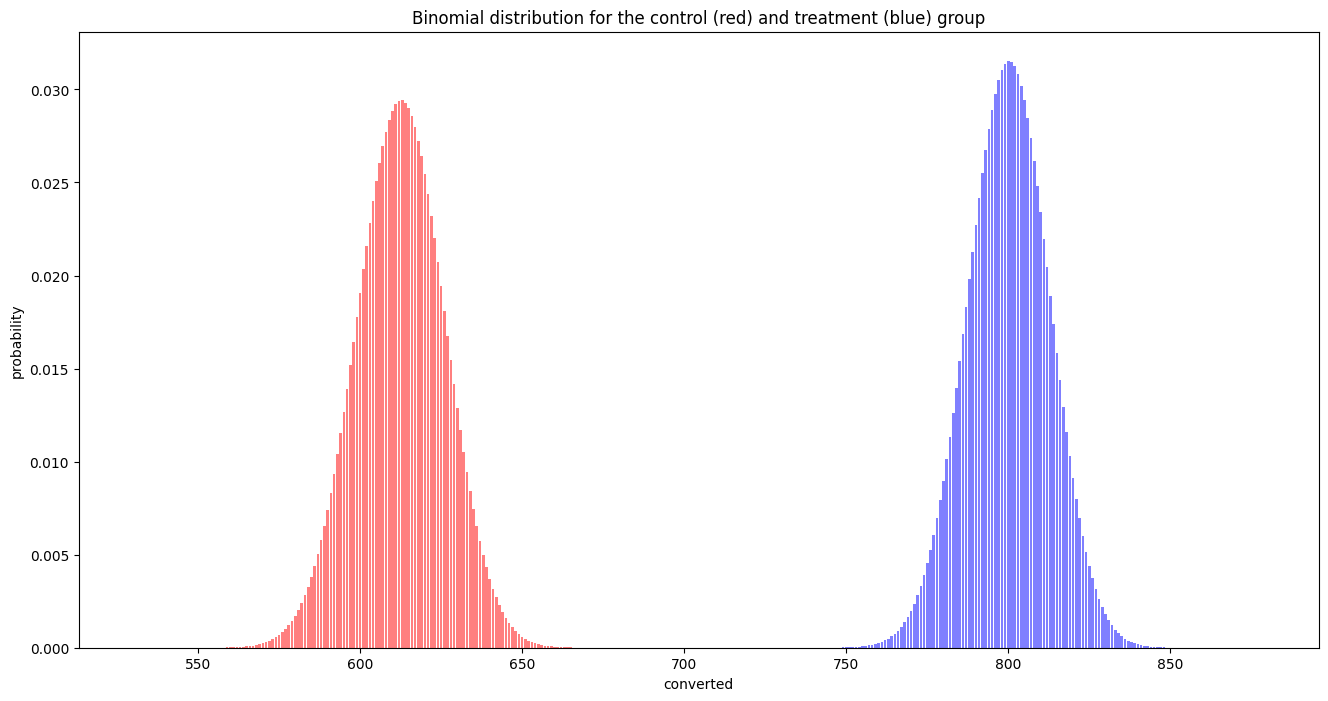

In [17]:
import scipy.stats as scs
from matplotlib.pyplot import subplots

# Control vs treatment
C_converted = 875
C_size = 1250
C_p = C_converted / C_size
T_converted = 1000
T_size = 1250
T_p = T_converted / T_size

ax = subplots(figsize=(16, 8))[1]


def plot_binomial_distribution(n, p, ax=None, **kwargs):
    x = np.arange(scs.binom.ppf(0.01, n, p) - 50, scs.binom.ppf(0.99, n, p) + 50)
    # x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.bar(x, y, **kwargs)


plot_binomial_distribution(C_converted, C_p, ax=ax, color="red", alpha=0.5)
plot_binomial_distribution(T_converted, T_p, ax=ax, color="blue", alpha=0.5)
ax.set_xlabel("converted")
ax.set_ylabel("probability")
ax.set_title("Binomial distribution for the control (red) and treatment (blue) group");

In [18]:
import matplotlib.pyplot as plt
from ipywidgets import interactive


def f(C_size, C_conv, T_size, T_conv):
    C_prob = C_conv / C_size
    T_prob = T_conv / T_size
    if C_prob > 1:
        C_prob = 1
    if T_prob > 1:
        T_prob = 1
    print("P-control: {}".format(C_prob))
    print("P-treatment: {}".format(T_prob))
    ax = subplots(figsize=(16, 8))[1]
    plot_binomial_distribution(
        C_conv,
        C_prob,
        ax=ax,
        color="red",
        alpha=0.5,
    )
    plot_binomial_distribution(
        T_conv,
        T_prob,
        ax=ax,
        color="blue",
        alpha=0.5,
    )
    ax.set_xlabel("converted")
    ax.set_ylabel("probability")
    ax.set_title(
        "Binomial distribution for the control (red) and treatment (blue) group"
    )
    plt.show()


interactive_plot = interactive(
    f,
    C_size=1250,
    C_conv=875,
    T_size=1250,
    T_conv=1000,
)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

interactive(children=(IntSlider(value=1250, description='C_size', max=3750, min=-1250), IntSlider(value=875, d…

## Normal Distribution

In [19]:
def plot_CI(ax, mu, std, sig_level=0.05, color="grey"):
    left, right = scs.norm.interval(1 - sig_level, loc=mu, scale=std)
    ax.axvline(left, c=color, linestyle="--", alpha=0.5)
    ax.axvline(right, c=color, linestyle="--", alpha=0.5)
    ax.annotate("0.05", (left, 10))
    ax.annotate("0.95", (right, 10))


def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)
    ax.axvline(x=mu, alpha=0.5, linestyle="--")
    ax.annotate("mu", (mu, 10))

    # Confidence interval.
    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)

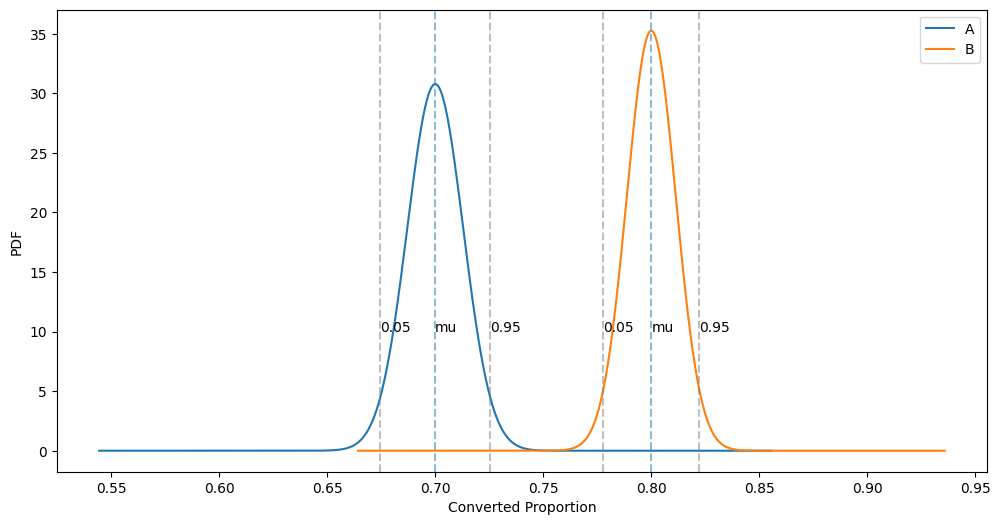

In [20]:
import math

p_A = 0.7
p_B = 0.8
A_total = 1250
B_total = 1250
A_converted = math.ceil(p_A * A_total)
B_converted = math.ceil(p_B * B_total)

# Standard error of the mean for both groups.
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(B_total)

# Plot the null and alternative hypothesis.
fig, ax = subplots(figsize=(12, 6))


plot_norm_dist(ax, p_A, SE_A, with_CI=True, label="A")
plot_norm_dist(ax, p_B, SE_B, with_CI=True, label="B")

plt.xlabel("Converted Proportion")
plt.ylabel("PDF")
plt.legend()

# Plot the null and the alternative hypothesis.

## Notes

This is basically the flow to do A/B testing. Pre:
- find out the existing base conversion rate first. You can't improve what you don't know
- set the target uplift percentage
- calculate the sample size required
- define the variant

Run experiment:
- sample size not reached - collect up to the sample size
- sample size is reached, but control conversion still haven't reached - continue collecting
    - if the base conversion still haven't hit after a period of time, stop the experiment
- otherwise, if it hits, stop the collection and evaluate

Collect data
- user visit the site
- based on the user identifier (hash of user id or email, return them control or treatment)
- submit the event as visited
- identify the CTA to indicate success, e.g. purchase, or clicking on an add
- submit the event as clicked
- the clicked over visited ratio is the conversion rate

Post experiment:
- we have a few options
  - turn off the A/B test
  - evaluate the A/B test, if significant, switch automatically
  - if not significant, revert back and generate report


